In [1]:
# %%
# General purpose packages for data processing
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

In [4]:
# Load data
normal = pd.read_csv("output_rudder.csv")
anomaly = pd.read_csv("output_rudder_attack.csv")

# Add labels
normal['Mode'] = 'Normal'
anomaly['Mode'] = 'Attack'

# Combine datasets
combined = pd.concat([normal, anomaly], axis=0, ignore_index=True)

In [5]:
# Preprocessing: Group data into chunks of 10 and extract features
def extract_features(data, group_size=10):
    features = []
    labels = []
    for i in range(0, len(data) - group_size + 1, group_size):
        chunk = data.iloc[i:i+group_size]
        # Compute statistical features
        mean_heading = chunk['heading'].mean()
        std_heading = chunk['heading'].std()
        min_heading = chunk['heading'].min()
        max_heading = chunk['heading'].max()
        range_heading = max_heading - min_heading

        mean_angle = chunk['rudder angle'].mean()
        std_angle = chunk['rudder angle'].std()
        min_angle = chunk['rudder angle'].min()
        max_angle = chunk['rudder angle'].max()
        range_angle = max_angle - min_angle

        mean_power = chunk['rudder power'].mean()
        std_power = chunk['rudder power'].std()
        min_power = chunk['rudder power'].min()
        max_power = chunk['rudder power'].max()
        range_power = max_power - min_power

        # Append features and label
        features.append([
            mean_heading, std_heading, min_heading, max_heading, range_heading,
            mean_angle, std_angle, min_angle, max_angle, range_angle,
            mean_power, std_power, min_power, max_power, range_power
        ])
        labels.append(chunk['Mode'].iloc[0])  # Assign label based on the first point in the group
    
    # Return as DataFrame
    feature_columns = [
        'mean_heading', 'std_heading', 'min_heading', 'max_heading', 'range_heading',
        'mean_angle', 'std_angle', 'min_angle', 'max_angle', 'range_angle',
        'mean_power', 'std_power', 'min_power', 'max_power', 'range_power'
    ]
    feature_df = pd.DataFrame(features, columns=feature_columns)
    feature_df['Mode'] = labels
    return feature_df

# Extract features from combined data
processed_data = extract_features(combined)

# Save processed data
processed_data.to_csv("processed_rudder.csv", index=False)

In [6]:
# Features and labels
X = processed_data.drop(columns=['Mode'])  # Features
y = processed_data['Mode']                # Labels

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Support Vector Classifier': SVC(kernel='linear', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
}

In [8]:
# Results container
results = {}


--- Evaluating Random Forest ---
Accuracy: 0.9983
F1-Score: 0.9983


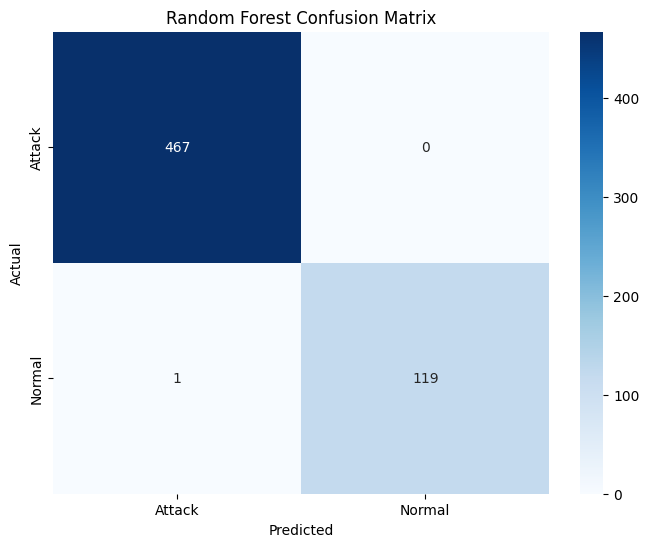


--- Evaluating Support Vector Classifier ---
Accuracy: 0.9983
F1-Score: 0.9983


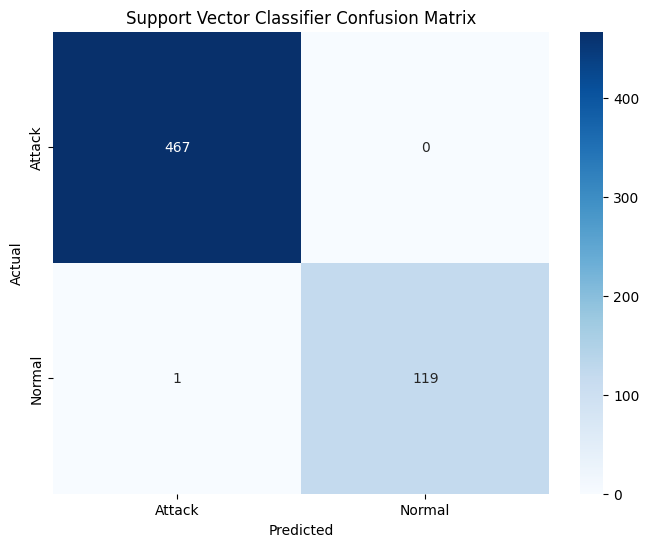


--- Evaluating K-Nearest Neighbors ---
Accuracy: 0.9983
F1-Score: 0.9983


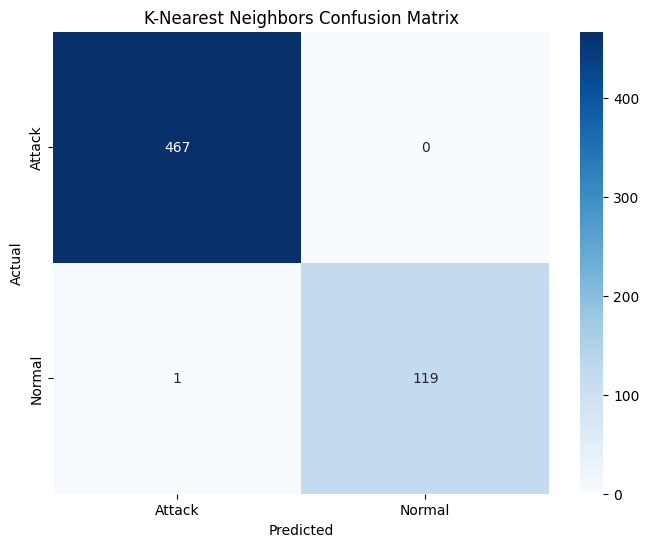

In [9]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    conf_matrix = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
    
    # Save results
    results[name] = {
        'Confusion Matrix': conf_matrix,
        'Accuracy': acc,
    }
    
    # Display metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [10]:
# Train final model (Random Forest performed the best in this example)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Save the model to a .pkl file
with open('IDS_rudder.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

Feature Importances:
          Feature  Importance
12      min_power    0.257135
10     mean_power    0.222082
13      max_power    0.210780
9     range_angle    0.113411
6       std_angle    0.078523
11      std_power    0.043721
14    range_power    0.041957
4   range_heading    0.011062
8       max_angle    0.008489
7       min_angle    0.005746
1     std_heading    0.003038
2     min_heading    0.001535
5      mean_angle    0.001443
3     max_heading    0.000641
0    mean_heading    0.000436


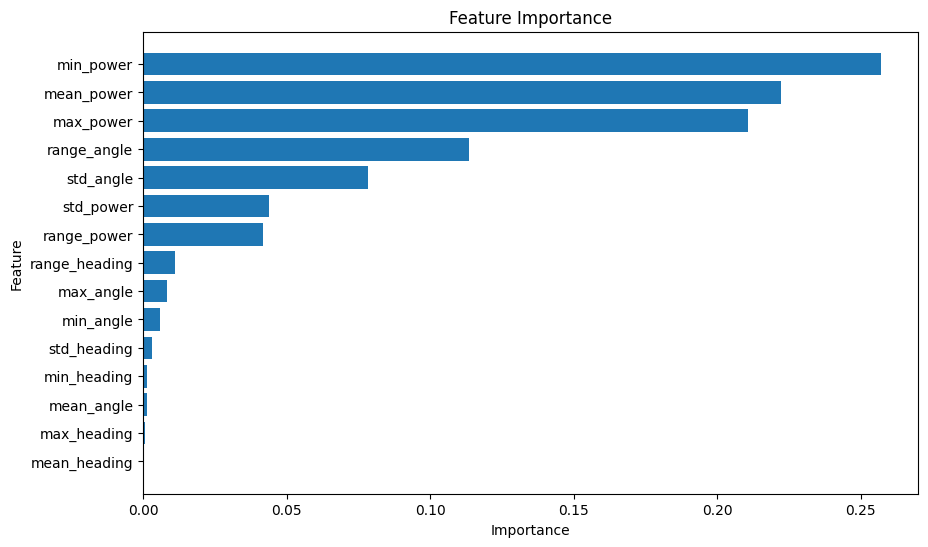

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `rf_model` is your trained Random Forest model
# Assuming `X_train` contains the feature data used for training

def plot_feature_importance(model, feature_names):
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Print feature importances
    print("Feature Importances:")
    print(feature_importance_df)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important at the top
    plt.show()

# Feature names
feature_names = [
    'mean_heading', 'std_heading', 'min_heading', 'max_heading', 'range_heading',
    'mean_angle', 'std_angle', 'min_angle', 'max_angle', 'range_angle',
    'mean_power', 'std_power', 'min_power', 'max_power', 'range_power'
]

# Plot feature importance
plot_feature_importance(rf_model, feature_names)
